In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
!pip install -r /content/drive/MyDrive/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.36.0 Requires-Python >=3.6,<3.10; 0.37.0 Requires-Python <3.12,>=3.7; 0.37.0 Requires-Python >=3.7,<3.10; 0.38.0 Requires-Python >=3.7,<3.11; 0.38.1 Requires-Python >=3.7,<3.11; 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10; 0.55.0 Requires-Python >=3.7,<3.11; 0.55.0rc1 Requires-Python >=3.7,<3.11; 0.55.1 R

In [4]:

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import silhouette_score

from optimisation import *

In [5]:

logcounts = pd.read_csv("/content/drive/MyDrive/Data/Dataset 2 — Perturb-seq/CRISPRn_whole_upr_logcounts.csv")

meta_data = pd.read_csv("/content/drive/MyDrive/Data/Dataset 2 — Perturb-seq/meta_CRISPRn_whole.csv")

# Merge and clean data for modeling
data = preprocess_data(logcounts, meta_data)

In [6]:
X_train, X_test, target_gene_train, target_gene_test, gRNA_train, gRNA_test = (
    get_train_test_grna(data))



In [7]:
# Define hyperparameter grid
param_grid = {
    'latent_dim_units': {
        (2, 3, 4, 5): [(256, 64),
                       (128, 32), (256, 64, 16), (256, 32)
                       ],
        (8, 12): [(256, 64),
                  (256, 64, 16)
          ]
        ,
        (18, 27): [(256, 64),
                   (256, 128)
                   ],
        (41, 62): [(256, 128),
                   (512, 128)
                   ],
        (72, 92): [(512, 256),
                       (512, 512)
                       ]
    },
    'activation': ['relu'],
    'optimizer': ['adam'],
    'learning_rate': [1e-4],
    'dropout': [0.0]
}

# Training settings
EPOCHS = 300
BATCH_SIZE = 256
#

# Grid search over hyperparameters
results_history = {}
for y_label in ["gRNA", "target_gene"]:
    results_history[y_label] = {}

    le = LabelEncoder()
    # Fit on training set only (important to avoid data leakage)
    y_train = le.fit_transform(target_gene_train if y_label == "target_gene" else gRNA_train)
    # Transform test set using the same encoder
    y_test = le.transform(target_gene_test if y_label == "target_gene" else gRNA_test)
    num_classes = len(np.unique(y_train))
    best_models_euclidean = {}
    silhouette_score_history_euclidean = []

    best_models_energy = {}
    silhouette_score_history_energy = []
    for latent_group, unit_options in param_grid['latent_dim_units'].items():
        for latent_dim in latent_group:
            # min_losses_dim = [100, 100]
            max_silhouette_score_dim_euclidean = [-1, -1]
            max_silhouette_score_dim_energy = [-1, -1]
            for units in unit_options:
                for activation in param_grid['activation']:
                    for optimizer_name in param_grid['optimizer']:
                        for learning_rate in param_grid['learning_rate']:
                            for dropout in param_grid['dropout']:
                                print(f"Training: latent_dim={latent_dim}, units={units}, "
                                      f"activation={activation}, optimizer={optimizer_name}, "
                                      f"lr={learning_rate}, dropout={dropout}")

                                # Build and train model
                                set_seed()
                                autoencoder, encoder = supervised_autoencoder(
                                    input_dim=X_train.shape[1],
                                    latent_dim=latent_dim,
                                    units=units,
                                    dropout=dropout,
                                    learning_rate=learning_rate,
                                    optimizer=optimizer_name,
                                    activation=activation,
                                    num_classes=num_classes,
                                    y_train=y_train
                                )

                                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                                set_seed()
                                history = autoencoder.fit(
                                    X_train,
                                    {"reconstruction": X_train, "classification": y_train},
                                    validation_split=0.2,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    verbose=1,
                                    callbacks=[early_stop]
                                )

                                # Validation loss
                                val_loss = min(history.history['val_loss'])

                                # Encode train/test data
                                X_test_latent = encoder.predict(X_test)
                                X_train_latent = encoder.predict(X_train)

                                # ---> EUCLIDEAN DISTANCE <---
                                distance_euclidean = compute_distance(X_train_latent, gRNA_train, method="euclidean")
                                threshold_euclidean = compute_threshold_and_plot_hist(distance_euclidean, method="euclidean")

                                # Label effects
                                distance_euclidean["effect"] = np.where(distance_euclidean > threshold_euclidean, "effect", "no effect")
                                effect_dict_euclidean = dict(zip(distance_euclidean.index, distance_euclidean["effect"]))
                                true_labels_effect_test_euclidean = np.array([effect_dict_euclidean.get(g) for g in gRNA_test])
                                true_labels_effect_train_euclidean = np.array([effect_dict_euclidean.get(g) for g in gRNA_train])

                                # Evaluate with Silhouette scores
                                sil_score_test_euclidean = silhouette_score(X_test_latent, true_labels_effect_test_euclidean, metric='euclidean')
                                sil_score_train_euclidean = silhouette_score(X_train_latent, true_labels_effect_train_euclidean, metric='euclidean')
                                print("Test set Silhouette score:", sil_score_test_euclidean)
                                print("Train set Silhouette score:", sil_score_train_euclidean)

                                # Keep best model per latent_dim
                                if sil_score_test_euclidean > max_silhouette_score_dim_euclidean[0]:
                                    max_silhouette_score_dim_euclidean = [sil_score_test_euclidean, sil_score_train_euclidean]
                                    best_models_euclidean[latent_dim] = {
                                        'autoencoder': autoencoder,
                                        'encoder': encoder,
                                        'history': history,
                                        'config': {
                                            'units': units,
                                            'activation': activation,
                                            'optimizer': optimizer_name,
                                            'learning_rate': learning_rate,
                                            'dropout': dropout
                                        }
                                    }
                                # ---> ENERGY DISTANCE <---
                                distance_energy = compute_distance(X_train_latent, gRNA_train, method="energy")
                                threshold_energy = compute_threshold_and_plot_hist(distance_energy, method="energy")

                                # Label effects
                                distance_energy["effect"] = np.where(distance_energy > threshold_energy, "effect", "no effect")
                                effect_dict_energy = dict(zip(distance_energy.index, distance_energy["effect"]))
                                true_labels_effect_test_energy = np.array([effect_dict_energy.get(g) for g in gRNA_test])
                                true_labels_effect_train_energy = np.array([effect_dict_energy.get(g) for g in gRNA_train])

                                # Evaluate with Silhouette scores
                                sil_score_test_energy = silhouette_score(X_test_latent, true_labels_effect_test_energy, metric='euclidean')
                                sil_score_train_energy = silhouette_score(X_train_latent, true_labels_effect_train_energy, metric='euclidean')
                                print("Test set Silhouette score:", sil_score_test_energy)
                                print("Train set Silhouette score:", sil_score_train_energy)

                                # Keep best model per latent_dim
                                if sil_score_test_energy > max_silhouette_score_dim_energy[0]:
                                    max_silhouette_score_dim_energy = [sil_score_test_energy, sil_score_train_energy]
                                    best_models_energy[latent_dim] = {
                                        'autoencoder': autoencoder,
                                        'encoder': encoder,
                                        'history': history,
                                        'config': {
                                            'units': units,
                                            'activation': activation,
                                            'optimizer': optimizer_name,
                                            'learning_rate': learning_rate,
                                            'dropout': dropout
                                        }
                                    }

            # Store silhouette results
            silhouette_score_history_euclidean.append([max_silhouette_score_dim_euclidean[0], max_silhouette_score_dim_euclidean[1]])
            silhouette_score_history_energy.append([max_silhouette_score_dim_energy[0], max_silhouette_score_dim_energy[1]])

    results_history[y_label]["euclidean"] = {
        "silhouette_score_history": silhouette_score_history_euclidean,
        "best_models": best_models_euclidean
    }
    results_history[y_label]["energy"] = {
        "silhouette_score_history": silhouette_score_history_energy,
        "best_models": best_models_energy
    }



Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 95/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - classification_accuracy: 0.0941 - classification_loss: 3.0848 - loss: 3.5607 - reconstruction_loss: 0.9511 - val_classification_accuracy: 0.0554 - val_classification_loss: 3.4304 - val_loss: 3.8865 - val_reconstruction_loss: 0.9137
Epoch 96/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - classification_accuracy: 0.0932 - classification_loss: 3.0788 - loss: 3.5548 - reconstruction_loss: 0.9513 - val_classification_accuracy: 0.0554 - val_classification_loss: 3.4303 - val_loss: 3.8864 - val_reconstruction_loss: 0.9139
Epoch 97/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - classification_accuracy: 0.0942 - classification_loss: 3.0727 - loss: 3.5488 - reconstruction_loss: 0.9515 - val_classification_accuracy: 0.0544 - val_classification_loss: 3.4302 - val_loss: 3.8865 - val_reconstruction_loss: 0.9141
Epoch 98/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - classification_a

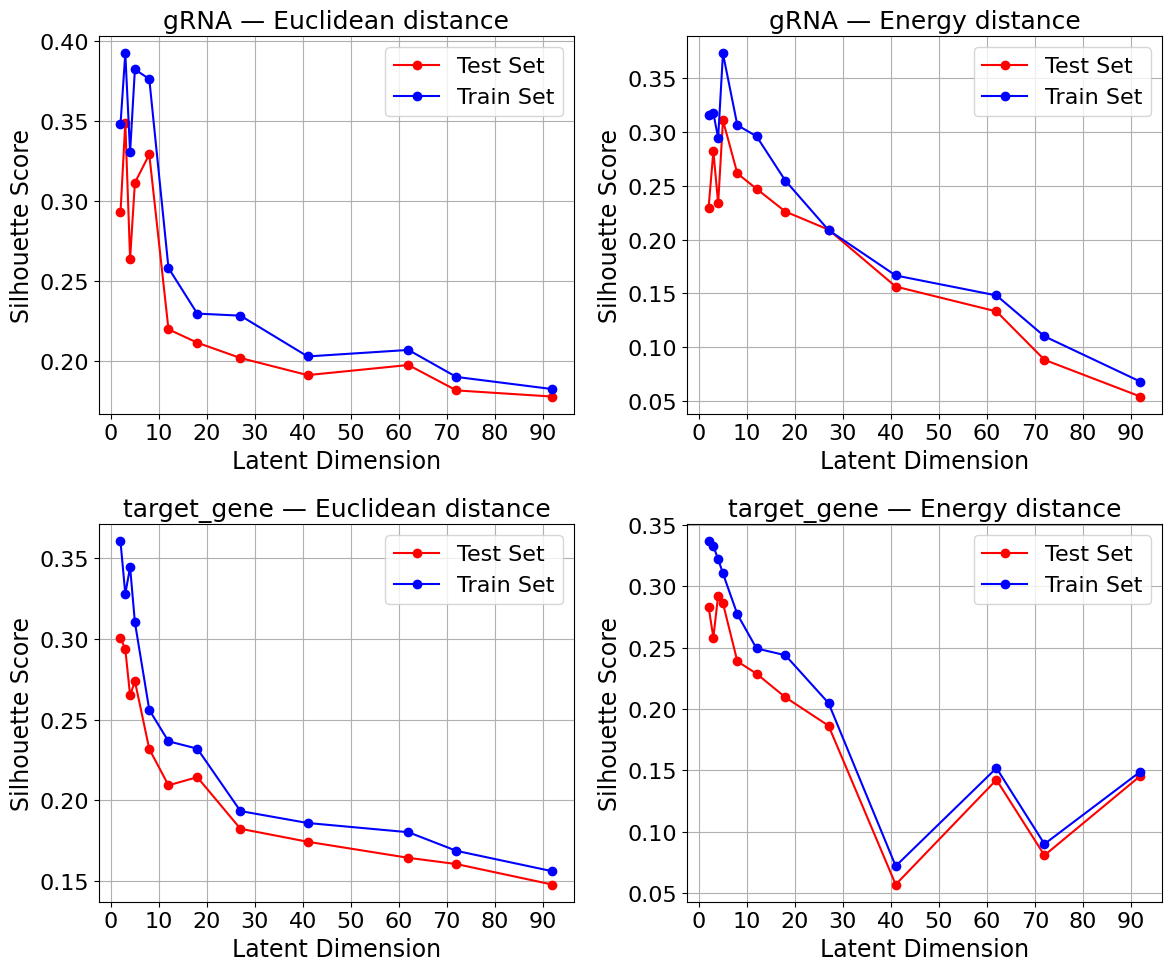

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    'font.size': 16,            # Base font size
    'axes.titlesize': 18,       # Title font size
    'axes.labelsize': 17,       # Axis label font size
    'xtick.labelsize': 16,      # X-tick label size
    'ytick.labelsize': 16,      # Y-tick label size
    'legend.fontsize': 16,      # Legend font size
})


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

latent_dim = [int(x) for group in param_grid['latent_dim_units'].keys() for x in group]

plot_idx = 0
for y_label in ["gRNA", "target_gene"]:
    for method in ["euclidean", "energy"]:
        ax = axes[plot_idx]
        plot_idx += 1

        sil_hist = np.array(results_history[y_label][method]["silhouette_score_history"])

        if len(sil_hist) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
            continue

        ax.plot(latent_dim, sil_hist[:, 0], label="Test Set", color="red", marker="o")
        ax.plot(latent_dim, sil_hist[:, 1], label="Train Set", color="blue", marker="o")

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.set_title(f"{y_label} — {method.capitalize()} distance")
        ax.set_xlabel("Latent Dimension")
        ax.set_ylabel("Silhouette Score")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.savefig("silhouette_scores_CRISPRn_whole.pdf")
plt.show()

from google.colab import files
files.download("silhouette_scores_CRISPRn_whole.pdf")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


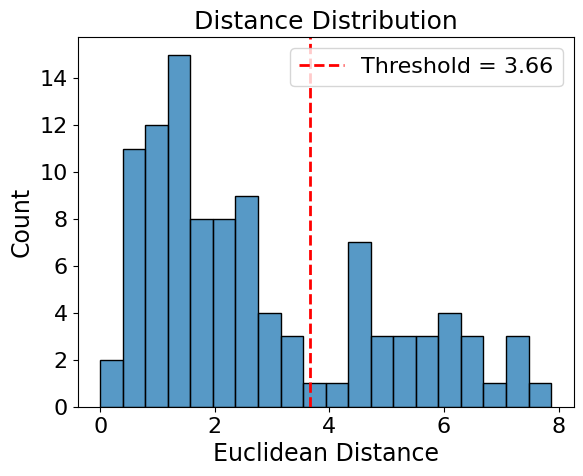

,count
effect,
no effect,72
effect,30


In [9]:
# Load best model for selected latent dimension
dimension = 12
method = "euclidean"
y_label = "target_gene"
best_models = results_history[y_label][method]["best_models"]
best_model = best_models[dimension]
best_autoencoder = best_model['autoencoder']
best_encoder = best_model['encoder']

# Encode train/test data using best encoder
X_test_latent = best_encoder.predict(X_test)
X_train_latent = best_encoder.predict(X_train)

# Compute distances from control and find optimal threshold

distance = compute_distance(X_train_latent, gRNA_train, method=method)
threshold = compute_threshold_and_plot_hist(distance, plot=True, method=method, log1p=False)

# Label each gRNA as 'effect' or 'no effect'
results = distance
results["effect"] = np.where(results > threshold, "effect", "no effect")
results["effect"].value_counts()

In [10]:
# Load best model for selected latent dimension
dimension = 12
method = "euclidean"
y_label = "target_gene"
best_models = results_history[y_label][method]["best_models"]
best_model = best_models[dimension]
best_autoencoder = best_model['autoencoder']
best_encoder = best_model['encoder']

plt.rcParams.update({
    'font.size': 14,            # Base font size
    'axes.titlesize': 16,       # Title font size
    'axes.labelsize': 15,       # Axis label font size
    'xtick.labelsize': 14,      # X-tick label size
    'ytick.labelsize': 14,      # Y-tick label size
    'legend.fontsize': 14,      # Legend font size
})

# Encode train/test data using best encoder
X_test_latent = best_encoder.predict(X_test)
X_train_latent = best_encoder.predict(X_train)

# Compute distances from control and find optimal threshold

plt.switch_backend("Agg")
distance = compute_distance(X_train_latent, gRNA_train, method=method)
threshold = compute_threshold_and_plot_hist(distance, plot=True, method=method, log1p=False)

for i, fig_num in enumerate(plt.get_fignums()):
    fig = plt.figure(fig_num)
    fig.savefig(f"histogram_sm_CRISPRn_whole.pdf", bbox_inches='tight')
# Label each gRNA as 'effect' or 'no effect'
plt.close('all')

results = distance
results["effect"] = np.where(results > threshold, "effect", "no effect")
results["effect"].value_counts()

from google.colab import files
files.download("histogram_sm_CRISPRn_whole.pdf")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Load best model for selected latent dimension
dimension = 12
method = "euclidean"
y_label = "target_gene"
best_models = results_history[y_label][method]["best_models"]
best_model = best_models[dimension]
best_autoencoder = best_model['autoencoder']
best_encoder = best_model['encoder']

plt.rcParams.update({
    'font.size': 16,            # Base font size
    'axes.titlesize': 18,       # Title font size
    'axes.labelsize': 17,       # Axis label font size
    'xtick.labelsize': 16,      # X-tick label size
    'ytick.labelsize': 16,      # Y-tick label size
    'legend.fontsize': 16,      # Legend font size
})

# Encode train/test data using best encoder
X_test_latent = best_encoder.predict(X_test)
X_train_latent = best_encoder.predict(X_train)

# Compute distances from control and find optimal threshold

plt.switch_backend("Agg")
distance = compute_distance(X_train_latent, gRNA_train, method=method)
threshold = compute_threshold_and_plot_hist(distance, plot=True, method=method, log1p=False)

for i, fig_num in enumerate(plt.get_fignums()):
    fig = plt.figure(fig_num)
    fig.savefig(f"histogram_lg_CRISPRn_whole.pdf", bbox_inches='tight')
# Label each gRNA as 'effect' or 'no effect'
plt.close('all')

results = distance
results["effect"] = np.where(results > threshold, "effect", "no effect")
results["effect"].value_counts()

from google.colab import files
files.download("histogram_lg_CRISPRn_whole.pdf")



40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Map each gRNA to its effect label
effect_dict = dict(zip(results.index, results["effect"]))

# Create label arrays for train/test sets
true_labels_effect_test = np.array([effect_dict.get(g) for g in gRNA_test])
true_labels_effect_train = np.array([effect_dict.get(g) for g in gRNA_train])

# Add effect labels back to full dataset
data["effect"] = data["gRNA_simplified"].map(effect_dict)

# Evaluate latent space separation with Silhouette scores
sil_score_test = silhouette_score(X_test_latent, true_labels_effect_test, metric='euclidean')
print("Test set Silhouette score:", sil_score_test)

sil_score_train = silhouette_score(X_train_latent, true_labels_effect_train, metric='euclidean')
print("Train set Silhouette score:", sil_score_train)

Test set Silhouette score: 0.20937547
Train set Silhouette score: 0.23661502


In [17]:
# Keep genes where gRNAs show mixed effects (both 'effect' and 'no effect')
mask = data.groupby("target_gene")["effect"].transform("nunique") > 1

# Filter and show unique gRNA–gene–effect combinations
filtered = data.loc[mask, ["gRNA_simplified", "target_gene", "effect"]]
filtered.drop_duplicates()

,gRNA_simplified,target_gene,effect
AAAGATGAGACTAAGT.1,sgRNA--QARS-5,QARS,effect
AAAGCAAAGGCTAGAC.1,sgRNA--QARS-6,QARS,no effect
AAAGCAAAGGTCATCT.1,sgRNA--TIMM23-3,TIMM23,no effect
AAATGCCAGTCCATAC.1,sgRNA--TIMM23-4,TIMM23,effect
AAATGCCTCCGCGGTA.1,sgRNA--QARS-4,QARS,effect
AACCGCGGTAATCGTC.1,sgRNA--TIMM23-5,TIMM23,effect


In [14]:
effect_results_by_dim = pd.DataFrame(
    columns=["dimension", "method", "y_label", "target_gene", "gRNA_simplified", "effect_label"]
)

methods = ["euclidean", "energy"]
y_labels = ["target_gene", "gRNA"]

for method in methods:
    for y_label in y_labels:
        for dimension in latent_dim:

            best_models = results_history[y_label][method]["best_models"]
            best_model = best_models[dimension]
            best_encoder = best_model['encoder']

            # Encode train/test data
            X_train_latent = best_encoder.predict(X_train)
            X_test_latent = best_encoder.predict(X_test)

            # Compute distances and threshold
            distance = compute_distance(X_train_latent, gRNA_train, method=method)
            threshold = compute_threshold_and_plot_hist(distance, plot=False, method=method, log1p=False)

            # Label gRNAs
            results = distance.copy()
            results["effect"] = np.where(results > threshold, "effect", "no effect")
            effect_dict = dict(zip(results.index, results["effect"]))
            data_copy = data.copy()
            data_copy["effect"] = data_copy["gRNA_simplified"].map(effect_dict)

            df = data_copy[["target_gene", "gRNA_simplified", "effect"]].drop_duplicates()
            df["effect_label"] = (df["effect"] == "effect").astype(int)

            # Add metadata columns
            df["dimension"] = dimension
            df["method"] = method
            df["y_label"] = y_label

            # Append properly
            effect_results_by_dim = pd.concat([effect_results_by_dim, df], ignore_index=True)

# Save to CSV
effect_results_by_dim.to_csv("CRISPRn_whole_effects.csv", index=False)

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [15]:
import pickle
import numpy as np

results_history_configs = {}

for y_label, method_dict in results_history.items():
    results_history_configs[y_label] = {}
    for method, info in method_dict.items():
        if "best_models" in info:
            # convert silhouette scores (which may be np.float32) into floats
            sil_scores = info.get("silhouette_score_history", [])
            sil_scores_clean = []
            for pair in sil_scores:
                if isinstance(pair, (list, tuple, np.ndarray)):
                    sil_scores_clean.append([float(x) if x is not None else None for x in pair])
                else:
                    sil_scores_clean.append(float(pair) if pair is not None else None)

            results_history_configs[y_label][method] = {
                "silhouette_score_history": sil_scores_clean,
                "best_models": {}
            }

            for latent_dim, model_info in info["best_models"].items():
                results_history_configs[y_label][method]["best_models"][latent_dim] = {
                    "config": model_info.get("config", {})
                }

# ✅ Save cleaned dictionary
with open("results_history_configs_CRISPRn_whole.pkl", "wb") as f:
    pickle.dump(results_history_configs, f)

In [16]:
import pickle
import numpy as np

results_history_configs = {}

for y_label, method_dict in results_history.items():
    results_history_configs[y_label] = {}
    for method, info in method_dict.items():
        if "best_models" in info:
            # convert silhouette scores (which may be np.float32) into floats
            sil_scores = info.get("silhouette_score_history", [])
            sil_scores_clean = []
            for pair in sil_scores:
                if isinstance(pair, (list, tuple, np.ndarray)):
                    sil_scores_clean.append([float(x) if x is not None else None for x in pair])
                else:
                    sil_scores_clean.append(float(pair) if pair is not None else None)

            results_history_configs[y_label][method] = {
                "silhouette_score_history": sil_scores_clean,
                "best_models": {}
            }

            for latent_dim, model_info in info["best_models"].items():
                results_history_configs[y_label][method]["best_models"][latent_dim] = {
                    "config": model_info.get("config", {})
                }

# ✅ Save cleaned dictionary
with open("results_history_configs_CRISPRn_whole.pkl", "wb") as f:
    pickle.dump(results_history_configs, f)